# Assignment 1: System Perspective

In [1]:
import Pkg
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()

  Activating project at `c:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1`
  No Changes to `C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\Manifest.toml`
Precompiling project...
  13657.8 ms  ✓ OPF
  1 dependency successfully precompiled in 39 seconds. 311 already precompiled.


In [2]:
using Revise
using OPF.Utils
using OPF.A1

using OPF.Utils: S_base

# Preparation

## Market Clearing as an optimization problem
The market operator clears the market by maximizing “social welfare”,
which is the area between the supply and demand curves.

The point where the demand and supply curves intersect is the **market clearing point**, or equilibrium point. At this point demands are happy because they get the energy they want at a price lower or equal to what they were willing to pay, and suppliers are happy because they get the price they want or more for the energy they supply.

The market clearing point is the point where both the **market clearing quantity** and **market clearing price** are determined. It can be found by solving an optimization problem, which is formulated as a simple linear program. 

NB: we consider here uniform pricing, i.e., all suppliers are **paid the same price** for the energy they supply, and all consumers pay the same price for the energy they consume.

$$
\begin{align}
\max_{\mathbf{p}^G, \mathbf{p}^D} \quad & \sum_{i=1}^{N_D} \pi_i^D p_i^D - \sum_{j=1}^{N_G} \pi_j^G p_j^G \\
\text{subject to} \quad & \sum_{j=1}^{N_G} p_j^G - \sum_{i=1}^{N_D} p_i^D = 0 \\
& 0 \leq p_i^D \leq P_i^D, \quad i = 1, \ldots, N_D \\
& 0 \leq p_j^G \leq P_j^G, \quad j = 1, \ldots, N_G
\end{align}
$$

Here:
- $N_D$ is the number of demand nodes
- $N_G$ is the number of generation nodes
- $p_i^D$ is the *elastic* scheduled power demand magnitude at node $i$
- $p_j^G$ is the scheduled power generation magnitude at node $j$
- $\pi_i^D$ is the demand bid price at node $i$
- $\pi_j^G$ is the generation bid price at node $j$
- $P_i^D$ is the maximum demand that can be offered at node $i$
- $P_j^G$ is the maximum generation that can be offered at node $j$

We can also write this as a minimization problem and in vector form:

$$
\begin{align}
\min_{\mathbf{p}^G, \mathbf{p}^D} \quad & \boldsymbol{\pi}^G \cdot \mathbf{p}^G - \boldsymbol{\pi}^D \cdot \mathbf{p}^D \\
\text{subject to} \quad & \mathbf{p}^G - \mathbf{p}^D = 0 \\
& 0 \leq \mathbf{p}^D \leq \mathbf{P}^D \\
& 0 \leq \mathbf{p}^G \leq \mathbf{P}^G
\end{align}
$$

Where $(\cdot)$ is the dot product and $\mathbf{p}^G$ and $\mathbf{p}^D$ are vectors of scheduled power generation and demand, respectively.

The constraint Eq. 2 ensures demand and generation are in balance.
The constraints Eq. 3 and Eq. 4 ensure that the scheduled power demand and generation are kept within their respective limits.

## Data collection and preparation

In order to solve a proper version of this optimization problem we need somewhat realistic pricing, generation and demand data. 

The assignment description is quite vague about data collection and preparation. It provides you some resources, but it does not explain how to use them. It is up to you to figure that out. I suppose from a pedagogical perspective this can either be a good or a bad thing. 

Collecting, curating and preparing data is an important, but time-consuming task in my experience. It doesn't hurt to become acquainted with it right now while you are still in the safety net of your studies. Real data is often (read: always) messy, incomplete, inconsistent and often not even correct! Dealing with this is a skill that you will need in your future career.

In my personal view it is not necessary to get to the core of the assignment, which is about formulating and solving a market clearing problem. The instructors *could* have saved you some time by providing you with a proper dataset, but didn't. So we have to spent some time doing it ourselves. I guess if you worked in a group you could draw straws ;)

I am lazy, so I used our AI overlord to transcribe PDF files to CSV. You can find these under `assignment1/data/`.

## Assumptions

Additionally the following assumptions are made (from the assignement description):

| Assumption | Implication for optimization |
|------------|-------------|
| The production cost of renewable units is assumed to be zero.  | $\pi_j^G = 0$ for all renewable units $j$ |
| Reneweable units offer their forecasted capacity, meaning their offer quantities vary over time. | $P_j^G$ is time-dependent for all renewable units $j$ (so $P_{j,t}^G$)|


## Generate demand data

The data is provided in the `assignment1/data/` folder. This data is in CSV format, which we will read into a DataFrame.


In [3]:
hours = 0:23

0:23

In [4]:
demands = prepare_demands(hours; save=true)
demands = demands ./ S_base
first(demands, 5)

Row,1,2,3,4,5,6,7,8,9,10,13,14,15,16,18,19,20
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.447726,0.394751,0.739784,0.271306,0.304113,0.54634,0.548351,0.677929,0.725925,0.775301,1.04365,0.805276,1.30453,0.405283,1.34459,0.756561,0.602701
2,0.412923,0.404595,0.781231,0.298886,0.294132,0.623305,0.550981,0.699339,0.759539,0.832412,1.00482,0.764079,1.36699,0.414827,1.38696,0.752979,0.564138
3,0.456887,0.386716,0.69567,0.307328,0.288733,0.579311,0.500617,0.687621,0.691433,0.801722,1.03483,0.86229,1.47624,0.37205,1.45274,0.818477,0.519461
4,0.454582,0.399823,0.743261,0.303192,0.312153,0.604052,0.486228,0.730599,0.745794,0.840916,1.14191,0.779663,1.25437,0.403912,1.68807,0.871636,0.549816
5,0.495185,0.445522,0.821604,0.350284,0.30476,0.6439,0.536535,0.806432,0.728181,0.844297,1.08549,0.819368,1.45397,0.469999,1.46196,0.784639,0.598051


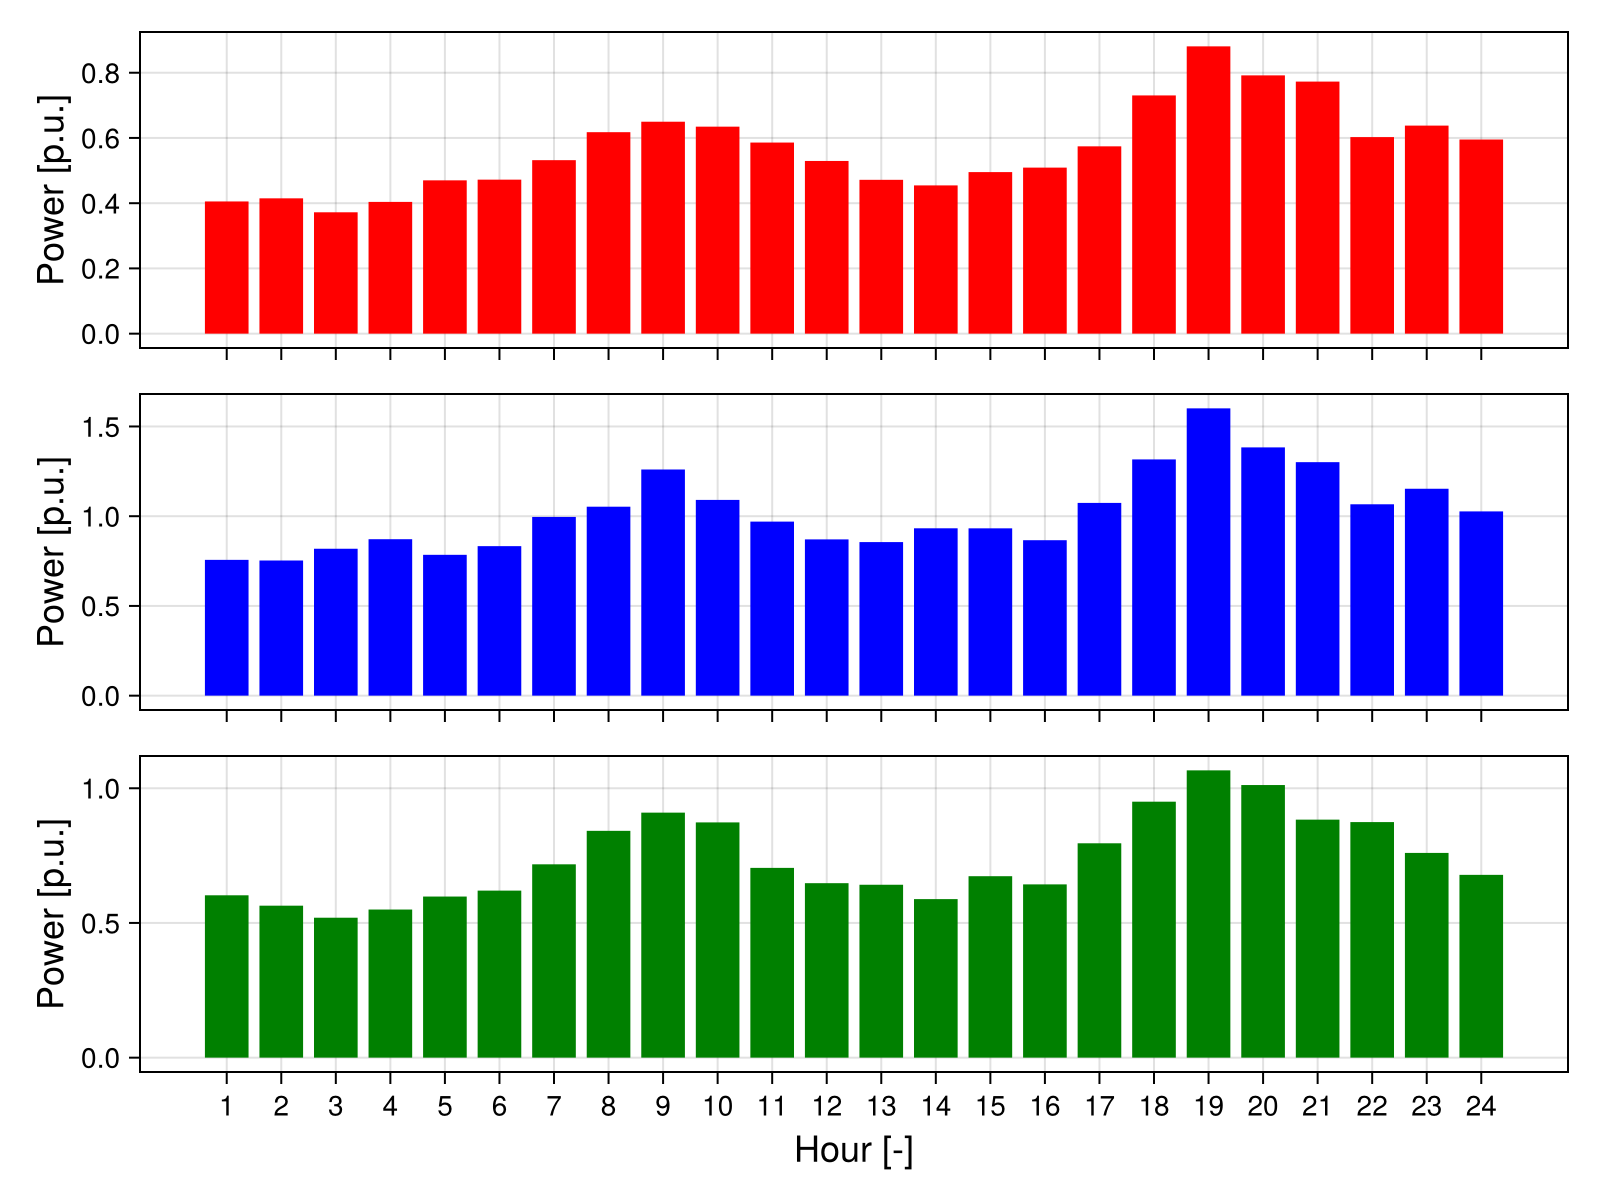

In [5]:
plot_powers(demands[:, Symbol.([16,19,20])]; colors=[:red, :blue,:green])

### Generate generation data

In [6]:
generation_fixed = prepare_generation_fixed()

# apply S_base p.u. scaling
col_map = Dict(
    :production_cost_D_pu   => :production_cost_D_MWh,
    :upreservecost_D_pu     => :upreservecost_D_MW,
    :downreservecost_D_pu   => :downreservecost_D_MW,
    :capacity_pu            => :capacity_MW,
    :maxupreserve_pu        => :maxupreserve_MW,
    :maxdownreserve_pu      => :maxdownreserve_MW,
)

# Apply scaling
for (new_col, old_col) in col_map
    generation_fixed[!, new_col] = generation_fixed[!, old_col] ./ S_base
end


generation_fixed

Row,id,bus,production_cost_D_MWh,upreservecost_D_MW,downreservecost_D_MW,capacity_MW,maxupreserve_MW,maxdownreserve_MW,maxupreserve_pu,upreservecost_D_pu,production_cost_D_pu,downreservecost_D_pu,maxdownreserve_pu,capacity_pu
,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,13.32,1.68,2.32,106.4,48,48,0.48,0.0168,0.1332,0.0232,0.48,1.064
2,2,2,13.32,1.68,2.32,106.4,48,48,0.48,0.0168,0.1332,0.0232,0.48,1.064
3,3,7,20.7,3.3,4.67,245.0,84,84,0.84,0.033,0.207,0.0467,0.84,2.45
4,4,13,20.93,4.07,3.93,413.7,216,216,2.16,0.0407,0.2093,0.0393,2.16,4.137
5,5,15,26.11,1.89,3.11,42.0,42,42,0.42,0.0189,0.2611,0.0311,0.42,0.42
6,6,15,10.52,5.48,3.52,108.5,36,36,0.36,0.0548,0.1052,0.0352,0.36,1.085
7,7,16,10.52,5.48,3.52,108.5,36,36,0.36,0.0548,0.1052,0.0352,0.36,1.085
8,8,18,6.02,4.98,5.02,280.0,60,60,0.6,0.0498,0.0602,0.0502,0.6,2.8
9,9,21,5.47,5.53,4.97,280.0,60,60,0.6,0.0553,0.0547,0.0497,0.6,2.8


In [7]:
generation_wind = prepare_generation_wind(hours.+18; save=true) ./ S_base
first(generation_wind, 5)

Row,3,5,16,21
,Float64,Float64,Float64,Float64
1,4.13891,3.22233,2.34399,2.79139
2,3.99948,4.00969,2.44623,2.6017
3,4.09179,3.69033,2.51093,2.5339
4,4.11056,3.85943,2.55519,2.63077
5,4.1989,3.55359,2.35908,2.81442


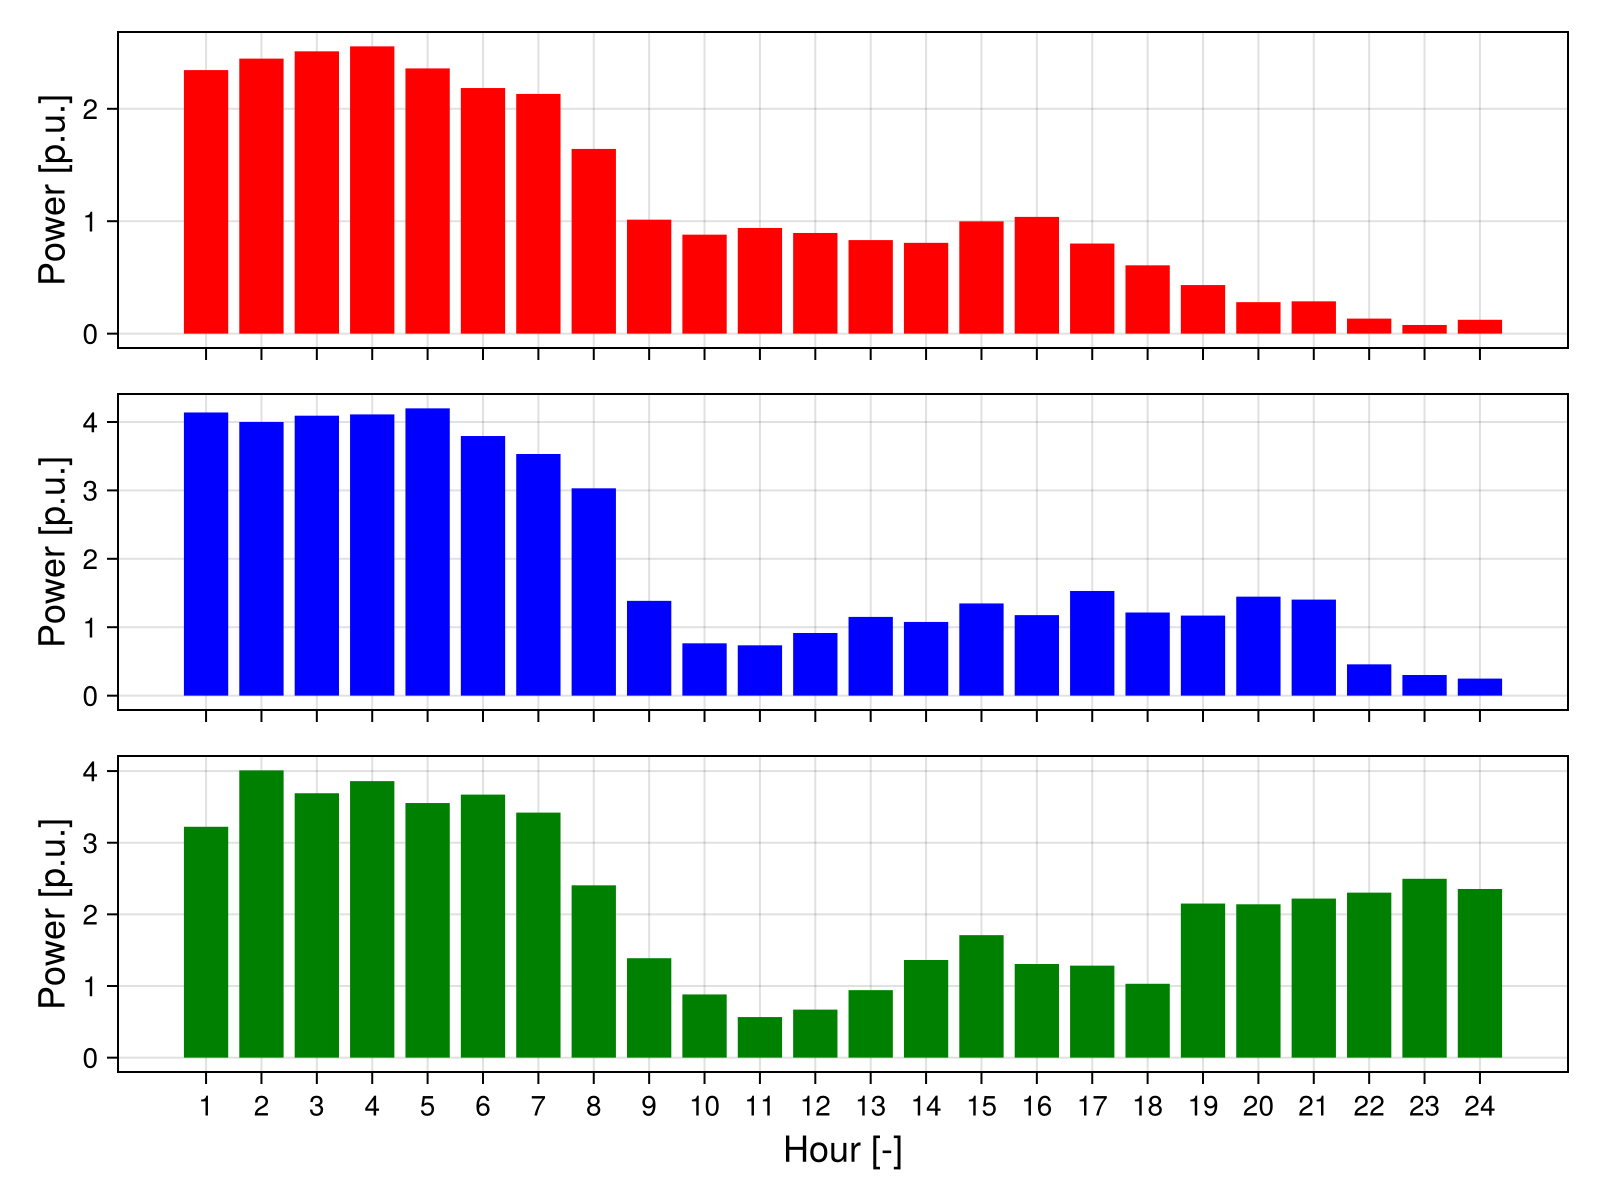

In [8]:
plot_powers(generation_wind[:, Symbol.([16,3,5])]; colors=[:red, :blue,:green])

## Generate demand price data

For the bid price of price-elastic demands, use comparatively high values (relative to the
generation cost of conventional units) to ensure that most demands are supplied. For
inspiration, check the real bid price data in Nord Pool.

The fixed generators have a maximum generator price of around 30 EUR/MWh. The price of the
demands should therefore be around 100 EUR/MWh.

In [9]:
demand_prices = prepare_demand_pricing(parse.(Int, names(demands))) 
demand_prices.price_pu = demand_prices.price ./ S_base
first(demand_prices, 5)

Row,bus,price,price_pu
,Int64,Float64,Float64
1,1,33.2352,0.332352
2,2,10.9769,0.109769
3,3,31.5374,0.315374
4,4,24.7137,0.247137
5,5,37.2592,0.372592


## Load network data

In [10]:
network = prepare_network()
network.capacity_pu = network.capacity_MW ./ S_base
first(network, 5)

Row,from_bus,to_bus,susceptance_pu,capacity_MW,capacity_pu
,Int64,Int64,Float64,Int64,Float64
1,1,2,0.0146,175,1.75
2,1,3,0.2253,175,1.75
3,1,5,0.0907,350,3.5
4,2,4,0.1356,175,1.75
5,2,6,0.205,175,1.75


## Step 1: Copper plate, single hour

This is a very basic market clearing problem. We just need some load, generation and price data for a single hour.

We have already prepared the data, so all we need to do is to load it and run the optimization problem.

### KKT conditions of clearing a single hour market

The problem in standard form can be written as:
$$
\begin{align}
\min_{\mathbf{p}^G, \mathbf{p}^D} \quad & (\boldsymbol{\pi}^G)^T \mathbf{p}^G - (\boldsymbol{\pi}^D)^T \mathbf{p}^D \\
\text{s.t.} \quad & \mathbf{p}^G - \mathbf{p}^D = 0 \quad : \quad \lambda \\
-\mathbf{p}^D & \leq 0 \quad : \quad \underline{\boldsymbol{\mu}}^D \\
\mathbf{p}^D - \mathbf{P}^D & \leq 0 \quad : \quad \overline{\boldsymbol{\mu}}^D \\
-\mathbf{p}^G & \leq 0 \quad : \quad \underline{\boldsymbol{\mu}}^G \\
\mathbf{p}^G - \mathbf{P}^G& \leq 0 \quad : \quad \overline{\boldsymbol{\mu}}^G
\end{align}
$$

We collect $\boldsymbol{\mu} = [\underline{\boldsymbol{\mu}}^D, \overline{\boldsymbol{\mu}}^D, \underline{\boldsymbol{\mu}}^G, \overline{\boldsymbol{\mu}}^G]$ and $\lambda$ as the Lagrange multipliers, and
$\mathbf{x} = [\mathbf{p}^G, \mathbf{p}^D]$ as the decision variables.

The Lagrangian is given by:
$$
\begin{align}
\mathcal{L}(\mathbf{x}, \lambda, \boldsymbol{\mu}) = f(\mathbf{x}) + \lambda \cdot h(\mathbf{x}) + \boldsymbol{\mu}^T g(\mathbf{x})
\end{align}
$$

Where: 
- $\mathbf{x} = [\mathbf{p}^G, \mathbf{p}^D]$ is the vector of decision variables
- $f(\mathbf{x}) = \boldsymbol{\pi}^G \cdot p^G - \boldsymbol{\pi}^D \cdot p^D$ is the objective function
- $h(\mathbf{x}) = \mathbf{p}^G - \mathbf{p}^D$ is the single equality constraint for system balance
- $g(\mathbf{x})$ is the vector of inequality constraints:
$$
g(\mathbf{x}) = \begin{bmatrix}
-\mathbf{p}^D \\
\mathbf{p}^D - \mathbf{P}^D \\
-\mathbf{p}^G \\
\mathbf{p}^G - \mathbf{P}^G
\end{bmatrix} \leq 0
$$

The KKT conditions for this problem are given by:
$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{x}} &= 0 \quad \text{(stationarity)} \\
h(\mathbf{x}) &= 0 \quad \text{(primal feasibility)} \\
g(\mathbf{x}) &\leq 0 \quad \text{(primal feasibility)} \\
\boldsymbol{\mu}^T g(\mathbf{x}) &= 0 \quad \text{(complementary slackness)} \\
\lambda &\geq 0 \quad \text{(dual variable non-negativity)}
\end{align}
$$

Taking partial derivatives and setting them to zero gives, for every generator $i$ and consumer $j$,

$$
\begin{aligned}
\frac{\partial\mathcal L}{\partial p^{G}_{i}}&:\qquad
  \pi^{G}_{i}-\lambda-\underline{\mu}^{G}_{i}+\overline{\mu}^{G}_{i}=0
\\[2mm]
\frac{\partial\mathcal L}{\partial p^{D}_{j}}&:\qquad
  -\pi^{D}_{j}+\lambda-\underline{\mu}^{D}_{j}+\overline{\mu}^{D}_{j}=0
\end{aligned}
$$

Re-arranging, each equation gives the same scalar λ:

$$
\boxed{\;
\lambda
  =\pi^{G}_{i}-\underline{\mu}^{G}_{i}+\overline{\mu}^{G}_{i}
  =\pi^{D}_{j}+\underline{\mu}^{D}_{j}-\overline{\mu}^{D}_{j}\;}
\tag{1}
$$

### 3.  Interpreting (1)

Analysing (1) and figuring out the values of the dual variables will tell us the role 
each generator $p^G_i$ and consumer $p^D_j$ plays in determining the market clearing 
quantity $p^G=p^D$ and market clearing price $\lambda$.

Complementary slackness condition for a generator $i$ means that:
$$
\begin{aligned}
\underline{\mu}^{G}_{i} \cdot (-p^{G}_{i}) &= 0 \\
\overline{\mu}^{G}_{i} \cdot (p^{G}_{i}-P^{G}_{i}) &= 0
\end{aligned}
$$

So for every generator either one of three cases may occur:

| Case                                                        | Multipliers        | (1) reduces to          | Economic meaning                                    |
| ------------------------------------------------------------------ | --------------------------- | ----------------------- | --------------------------------------------------- |
| 1. **Generator** $i$ strictly inside its band $0<p^{G}_{i}<P^{G}_{i}$ | $\underline{\mu}^{G}_{i}=\overline{\mu}^{G}_{i}=0$                        | $\lambda=\pi^{G}_{i}$   | Generator sets the market clearing price                        |
| 2. Generator at **lower** limit $p^{G}_{i}=0$                         | $\underline{\mu}^{G}_{i}>0$, $\overline{\mu}^{G}_{i}=0$ | $\lambda\le\pi^{G}_{i}$ | Price is not high enough to be dispatched       |
| 3. Generator at **upper** limit $p^{G}_{i}=P^{G}_{i}$                 | $\overline{\mu}^{G}_{i}>0$, $\underline{\mu}^{G}_{i}=0$  | $\lambda\ge\pi^{G}_{i}$ | Generator runs profitably at max capacity |

And for demands we have a similar table:
| Case                                                        | Multipliers        | (1) reduces to          | Economic meaning                                    |
| ------------------------------------------------------------------ | ----------------------------- | ----------------------- | --------------------------------------------------- |
| 1. **Demand** $j$ strictly inside its band $0<p^{D}_{j}<P^{D}_{j}$ | $\underline{\mu}^{D}_{j}=\overline{\mu}^{D}_{j}=0$                        | $\lambda=\pi^{D}_{j}$   | Price equals marginal demand bid                          |
| 2. Demand at **lower** limit $p^{D}_{j}=0$                         | $\underline{\mu}^{D}_{j}>0$, $\overline{\mu}^{D}_{j}=0$ | $\lambda\ge\pi^{D}_{j}$ | Price too high for load        |
| 3. Demand at **upper** limit $p^{D}_{j}=P^{D}_{j}$                 | $\overline{\mu}^{D}_{j}>0$, $\underline{\mu}^{D}_{j}=0$  | $\lambda\le\pi^{D}_{j}$ | Load is fully satisfied |

### 4. Finding the market clearing price $\lambda$ and quantity $p^G=p^D$

The conditions above also tell us how to find the market clearing price and quantity, 
namely one of three things can occur:
1. There is a generator that sets the price, i.e., $\lambda=\pi^{G}_{i}$ for some $i$.
2. There is a demand that sets the price, i.e., $\lambda=\pi^{D}_{j}$ for some $j$.
3. The price is set by the intersection of the supply and demand curves, i.e., $\lambda=\pi^{G}_{i}=\pi^{D}_{j}$ for some $i$ and $j$.

So in order to find the marginally active demand or supply bid that sets the price, we build:
1. **Supply curve**

   * Sort generator blocks in **ascending** order of $\pi^{G}$.
   * Build the cumulative sum of quantities $Q_k^{\text{supply}}=\sum_{i=1}^{k}P^{G}_{(i)}$.

2. **Demand curve**

   * Sort demand blocks in **descending** order of $\pi^{D}$.
   * Build the cumulative sum of quantities $Q_\ell^{\text{demand}}=\sum_{j=1}^{\ell}P^{D}_{(j)}$.

And find the point where one exceeds the other, i.e.:

$$
Q_k^{\text{supply}}\;\;\ge\;\;Q_\ell^{\text{demand}}
$$

Visually that looks like:

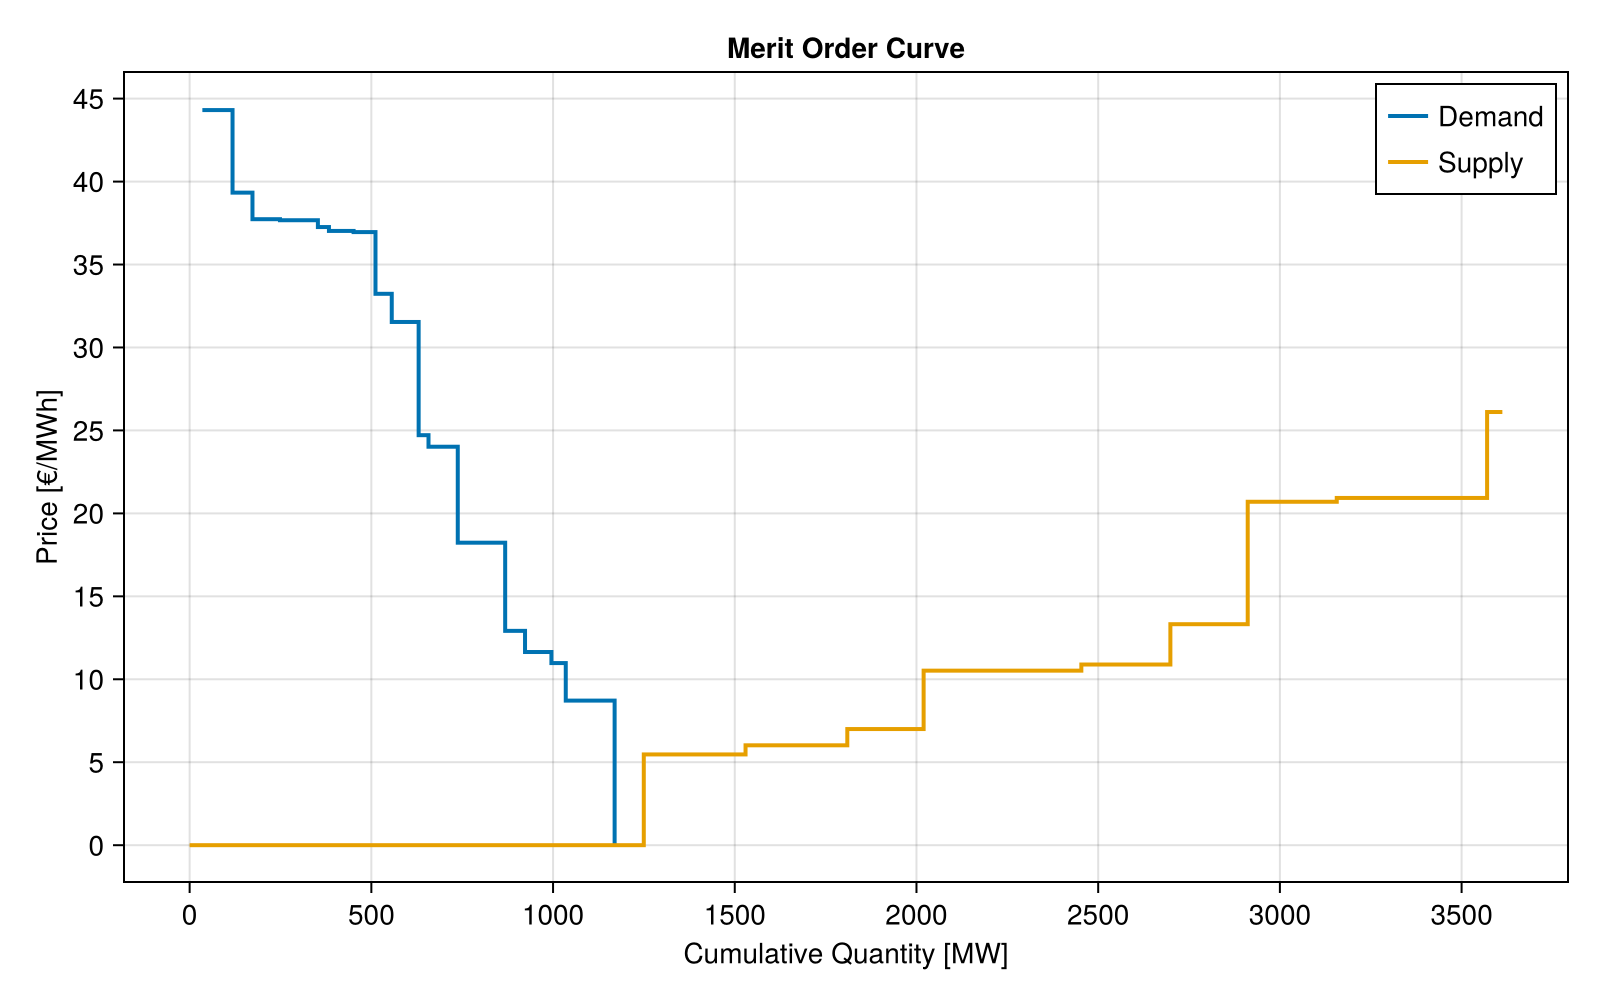

In [11]:
hour = 1

demand_cost = Dict(demand_prices.bus .=> demand_prices.price)
generation_cost = Dict(generation_fixed.bus .=> generation_fixed.production_cost_D_MWh)

# `demand_bids`: Vector of (quantity, price) tuples for demand (unsorted).
demand_bids = [(demand * S_base, price) for (demand, price) in zip(demands[hour, :], demand_prices.price)]

# `generation_bids`: Vector of (quantity, price) tuples for generation (unsorted).
generation_bids = [(generation, price) for (generation, price) in zip(generation_fixed.capacity_MW, generation_fixed.production_cost_D_MWh)]
generation_bids = vcat(generation_bids, [(generation * S_base, 0.0) for generation in generation_wind[hour, :]])

fig = plot_merit_order(demand_bids, generation_bids)

Where we see that for the first hour the marginal generator is wind with
a marginal cost $\pi^{G} = 0$ EUR/MWh. Hence the market clearing price is determined to 
be $\lambda = \pi^{G}= 0$ EUR/MWh.

We can also compute this numerically, but it will give the same result as the supply-demand 
curve.

### Copper plate with only one hour market clearing

In [12]:
model, results = market_clearing(1:1; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
)
results[:system]

Row,CP,SW,P_G_total,P_D_total
,Float64,Float64,Float64,Float64
1,-0.0,3.2008,11.6941,11.6941


# Step 2: Copper-Plate, Multiple Hours

## Without storage

In [13]:
model, results = market_clearing(1:24; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
    use_storage=false,
)
@info "Total social welfare without storage: $(round(sum(results[:system].SW)))"

┌ Info: Total social welfare without storage: 92.0
└ @ Main c:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X32sZmlsZQ==.jl:9


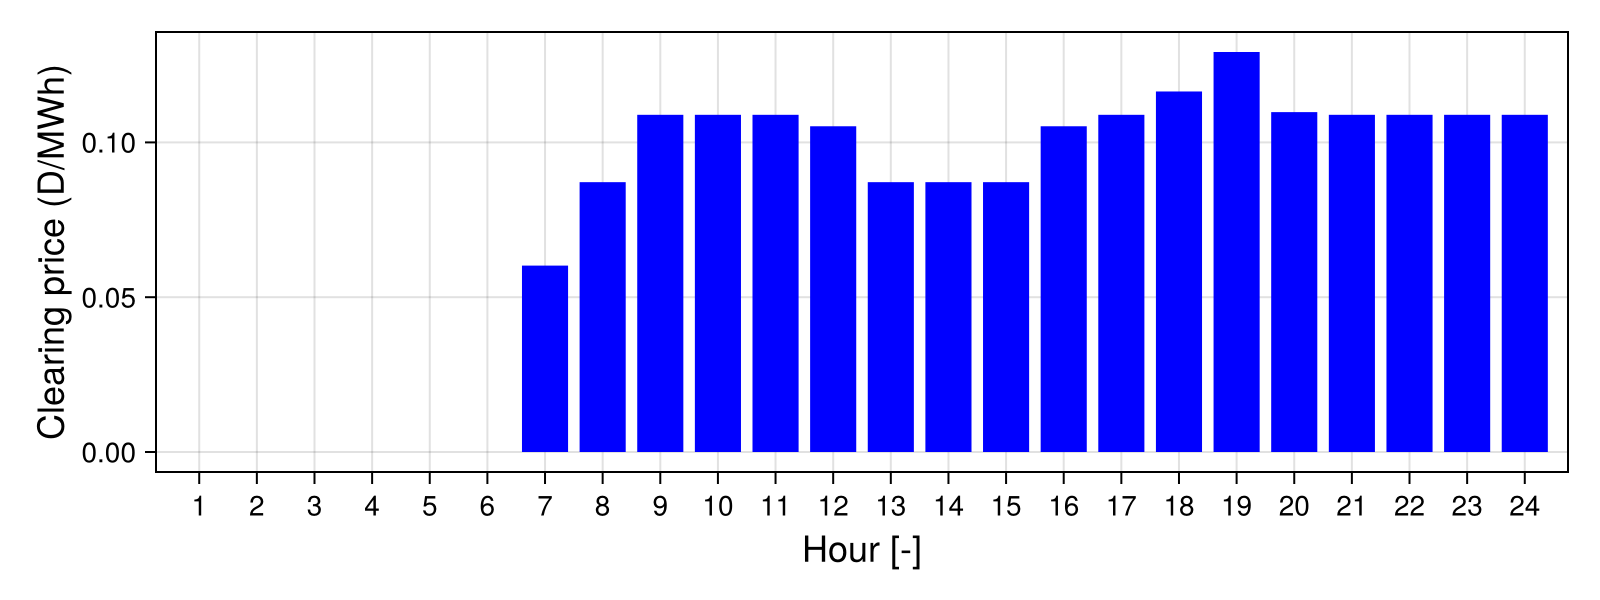

In [14]:
plot_value(model, :CP; ylabel="Clearing price (D/MWh)")

## With storage

Specifications of pumped hydro storage: [Technical Review of Existing Norwegian Pumped Storage Plants](https://www.mdpi.com/1996-1073/13/18/4918)

We will assume the following parameters for the storage:

| Parameter | Value |
|-----------|-------|
| P_ch_max | 200.0 MW |
| P_dis_max | 200.0 MW |
| E_cap | 1000.0 MWh |
| E0 | 0.0 MWh |
| η_ch | 0.90 |
| η_dis | 0.92 |

In [26]:
model_s, results = market_clearing(1:24; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
    use_storage=true,
)
@info "Total social welfare with storage: $(round(sum(results[:system].SW)))"

┌ Info: Total profit from storage: 1.00361709245395
└ @ OPF.A1 C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\OPF.jl\src\A1\model.jl:270
┌ Info: Total social welfare with storage: 93.0
└ @ Main c:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X35sZmlsZQ==.jl:9


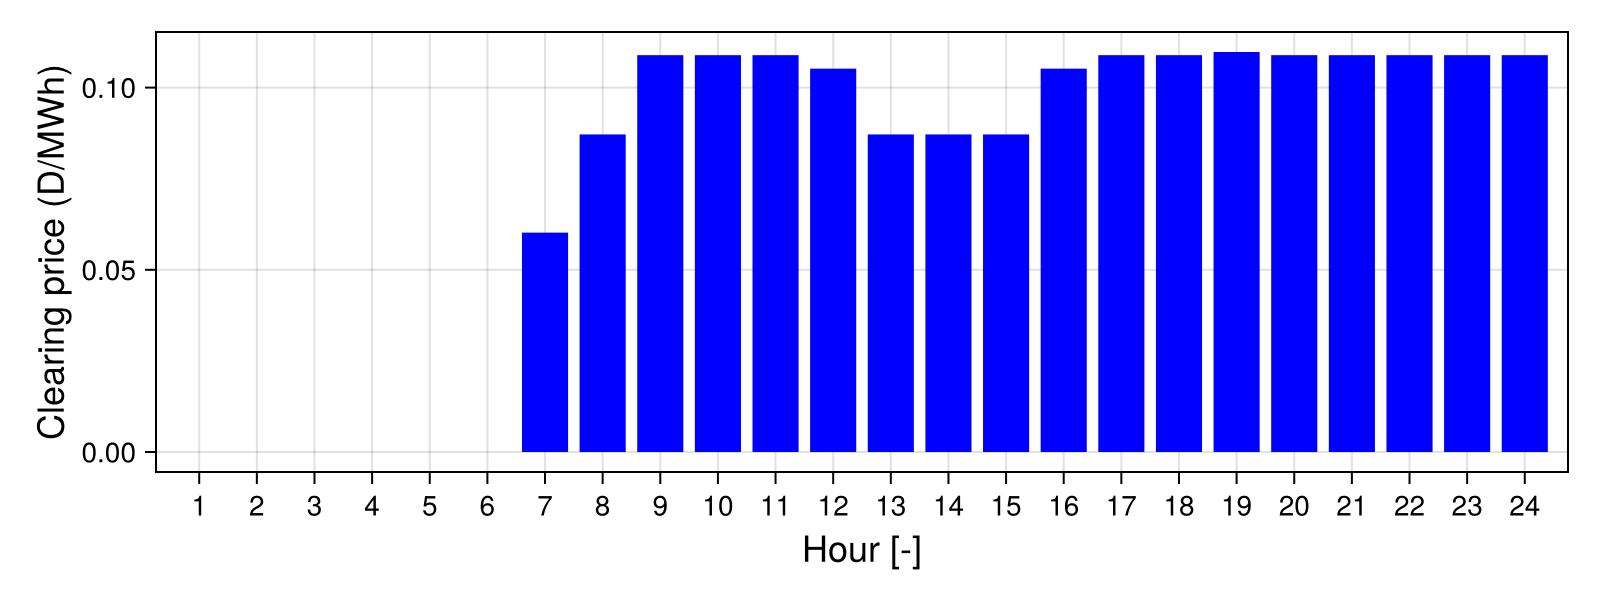

In [27]:
plot_value(model_s, :CP; ylabel="Clearing price (D/MWh)")

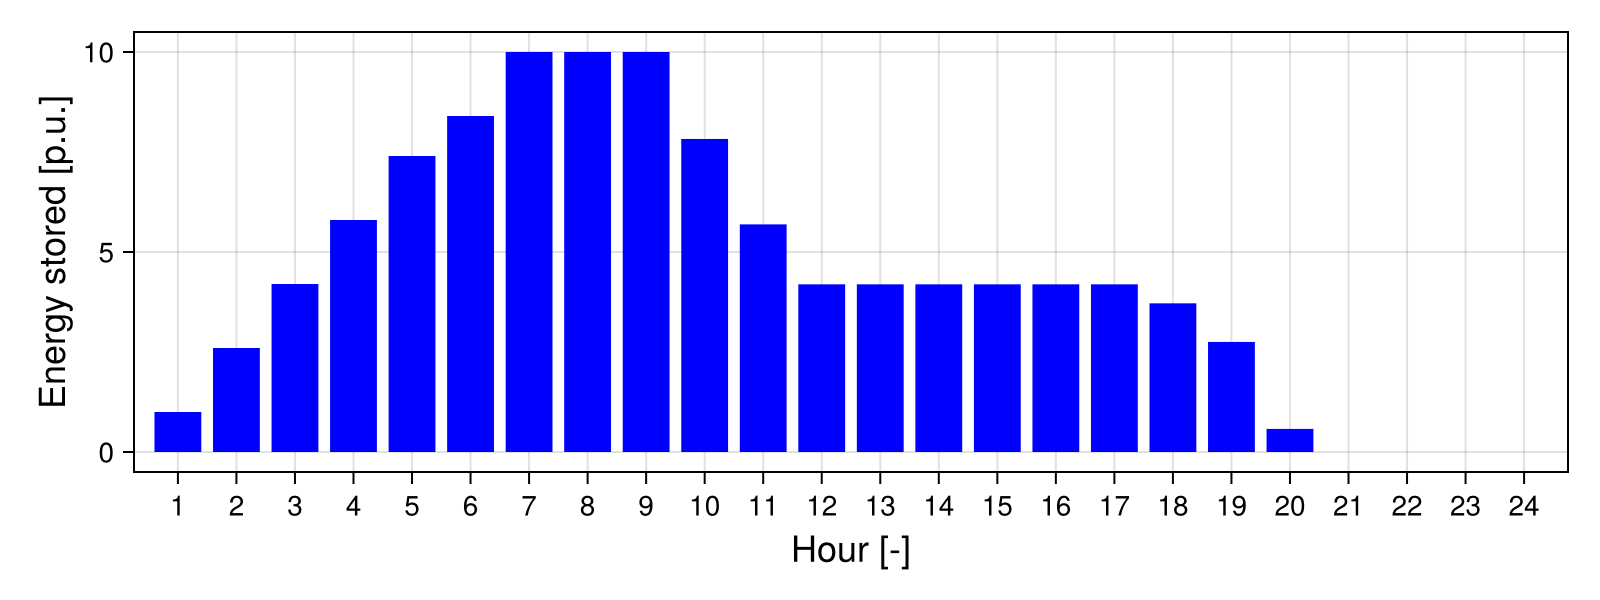

In [28]:
plot_value(model_s, :E; ylabel="Energy stored [p.u.]")

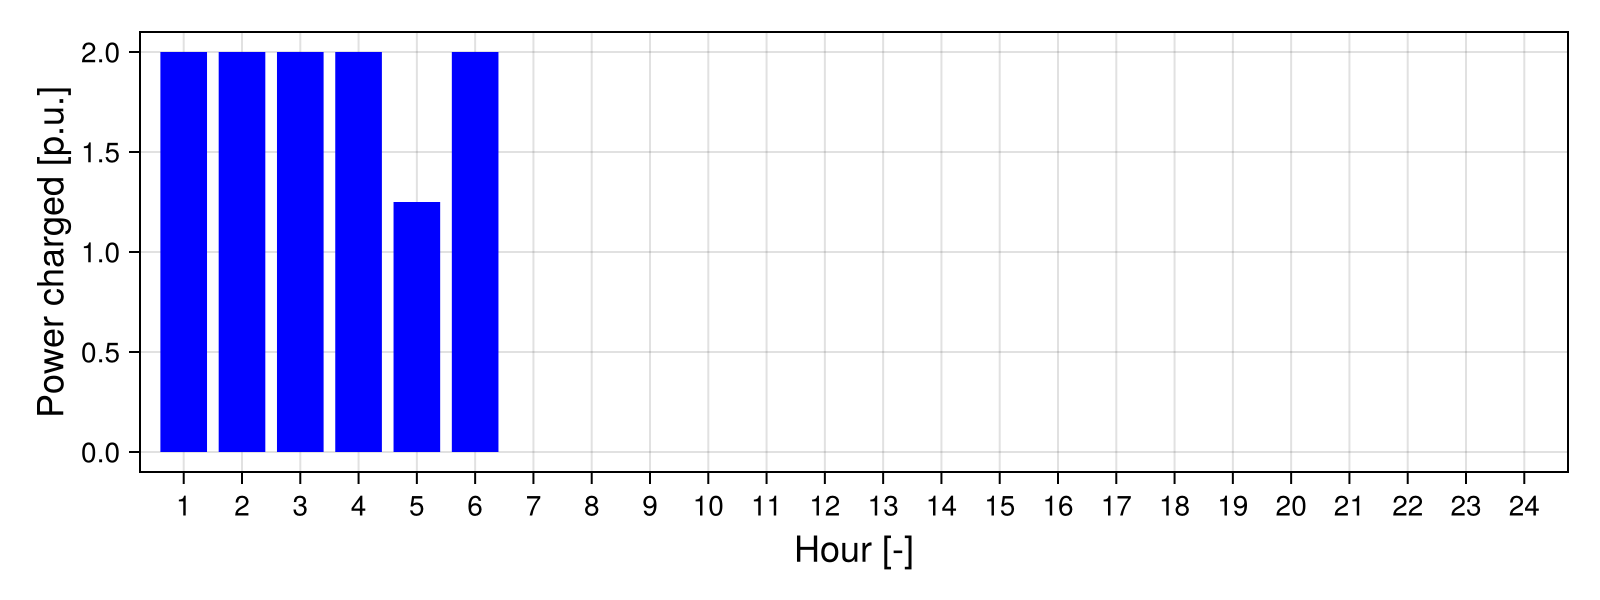

In [29]:
plot_value(model_s, :P_ch; ylabel="Power charged [p.u.]")

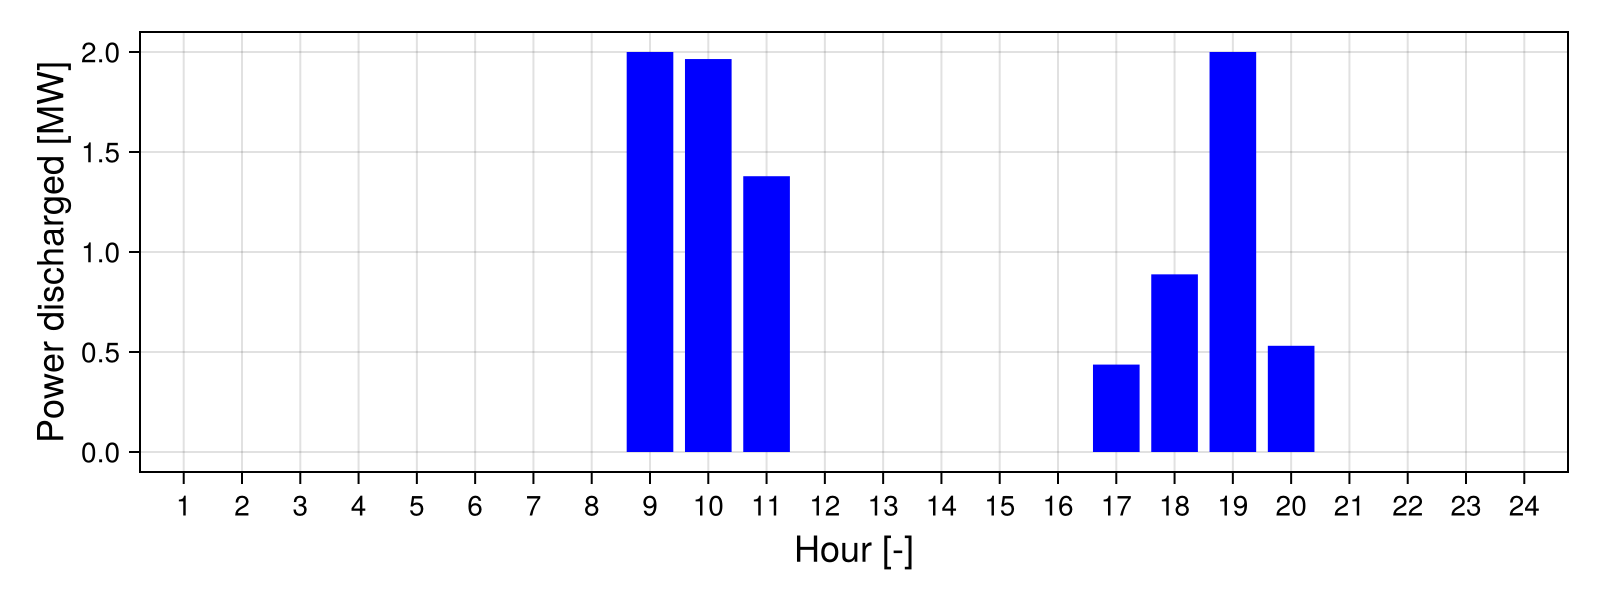

In [30]:
plot_value(model_s, :P_dis; ylabel="Power discharged [MW]", offset=0)

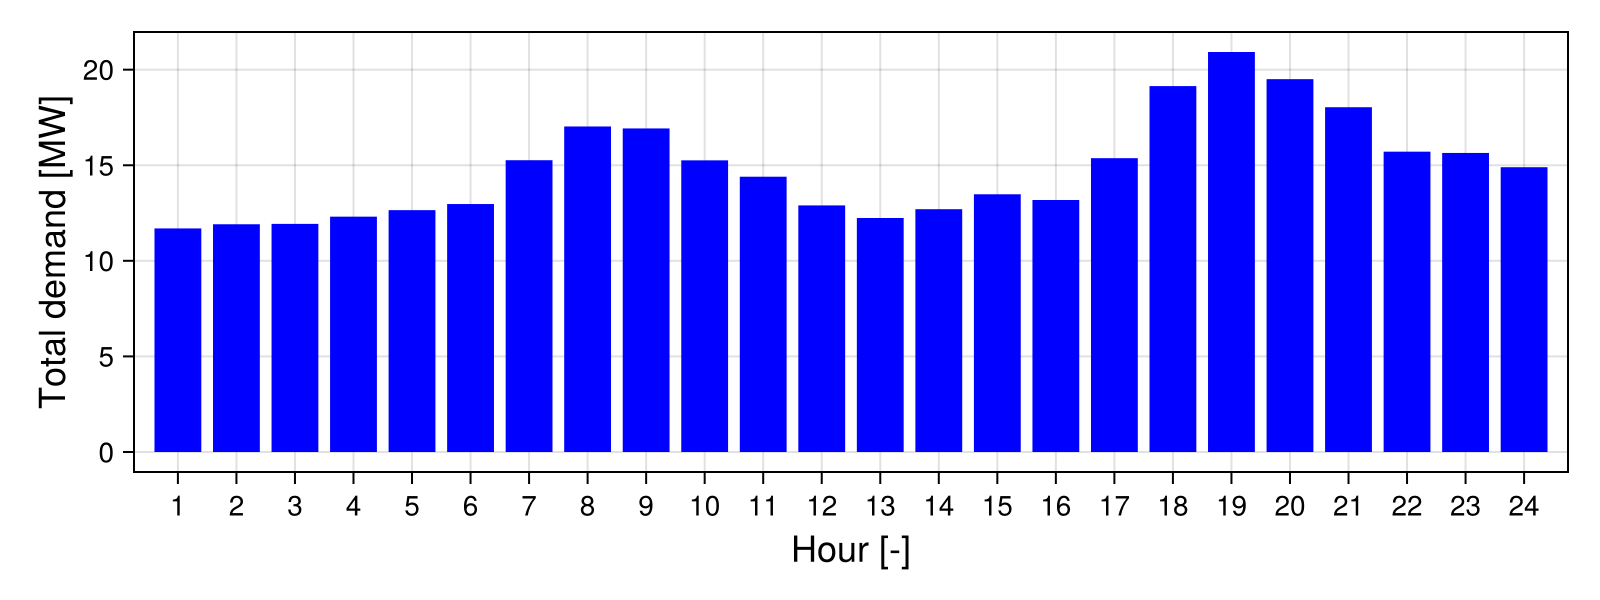

In [31]:
plot_value(results[:system].P_D_total; ylabel="Total demand [MW]", offset=0)

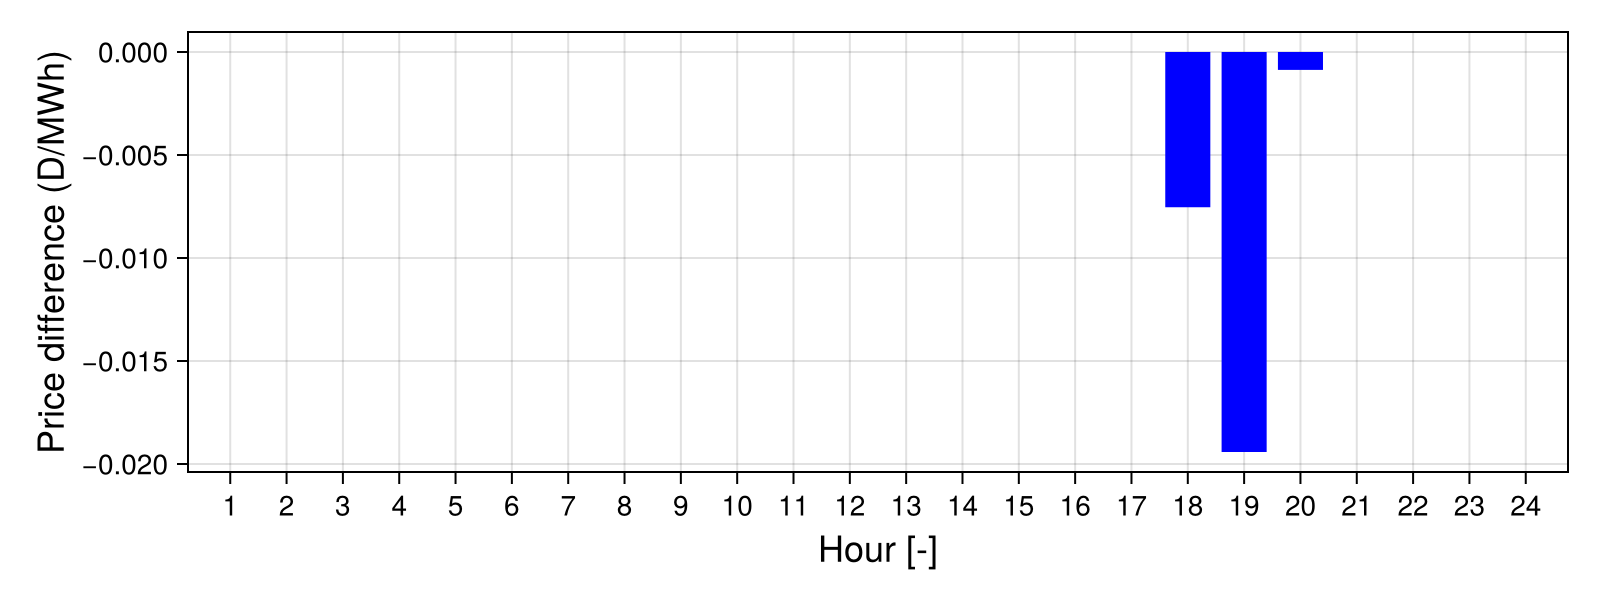

In [32]:
dCP = Vector(value.(model_s[:CP]) .- value.(model[:CP]))
plot_value(dCP; ylabel="Price difference (D/MWh)", offset=0)

# Step 3: Network Constraints

We now add the following (linearized) DC powerflow constraints to the optimization problem:

$$
\begin{align}
P_i = \sum_{k \in \Phi} b_{ik}(\theta_i - \theta_k) \\
\end{align}
$$

Where:
- $P_i$ is the net power injection at node $i$ in per unit (p.u.)
- $b_{ik}$ is the susceptance of the line between nodes $i$ and $k$ in per unit (p.u.)
- $\theta_i - \theta_k$ is the voltage angle difference between nodes $i$ and $k$ in radians
- $\Phi$ is the set of nodes connected to node $i$

In [128]:
model_n, results = market_clearing(1:24; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
    use_storage=false,
    use_network=true,
)
results[:system]

Row,CP,SW,P_G_total,P_D_total
,Float64,Float64,Float64,Float64
1,-0.0,3.2008,11.6941,11.6941
2,-0.0,3.2338,11.9121,11.9121
3,-0.0,3.21794,11.9321,11.9321
4,-0.0,3.32443,12.31,12.31
5,-0.0,3.4483,12.6502,12.6502
6,-0.0,3.55082,12.9699,12.9699
7,0.0657789,4.08931,14.434,14.434
8,0.079725,4.28162,16.0315,16.0315
9,0.0834987,4.24384,17.7737,17.7737


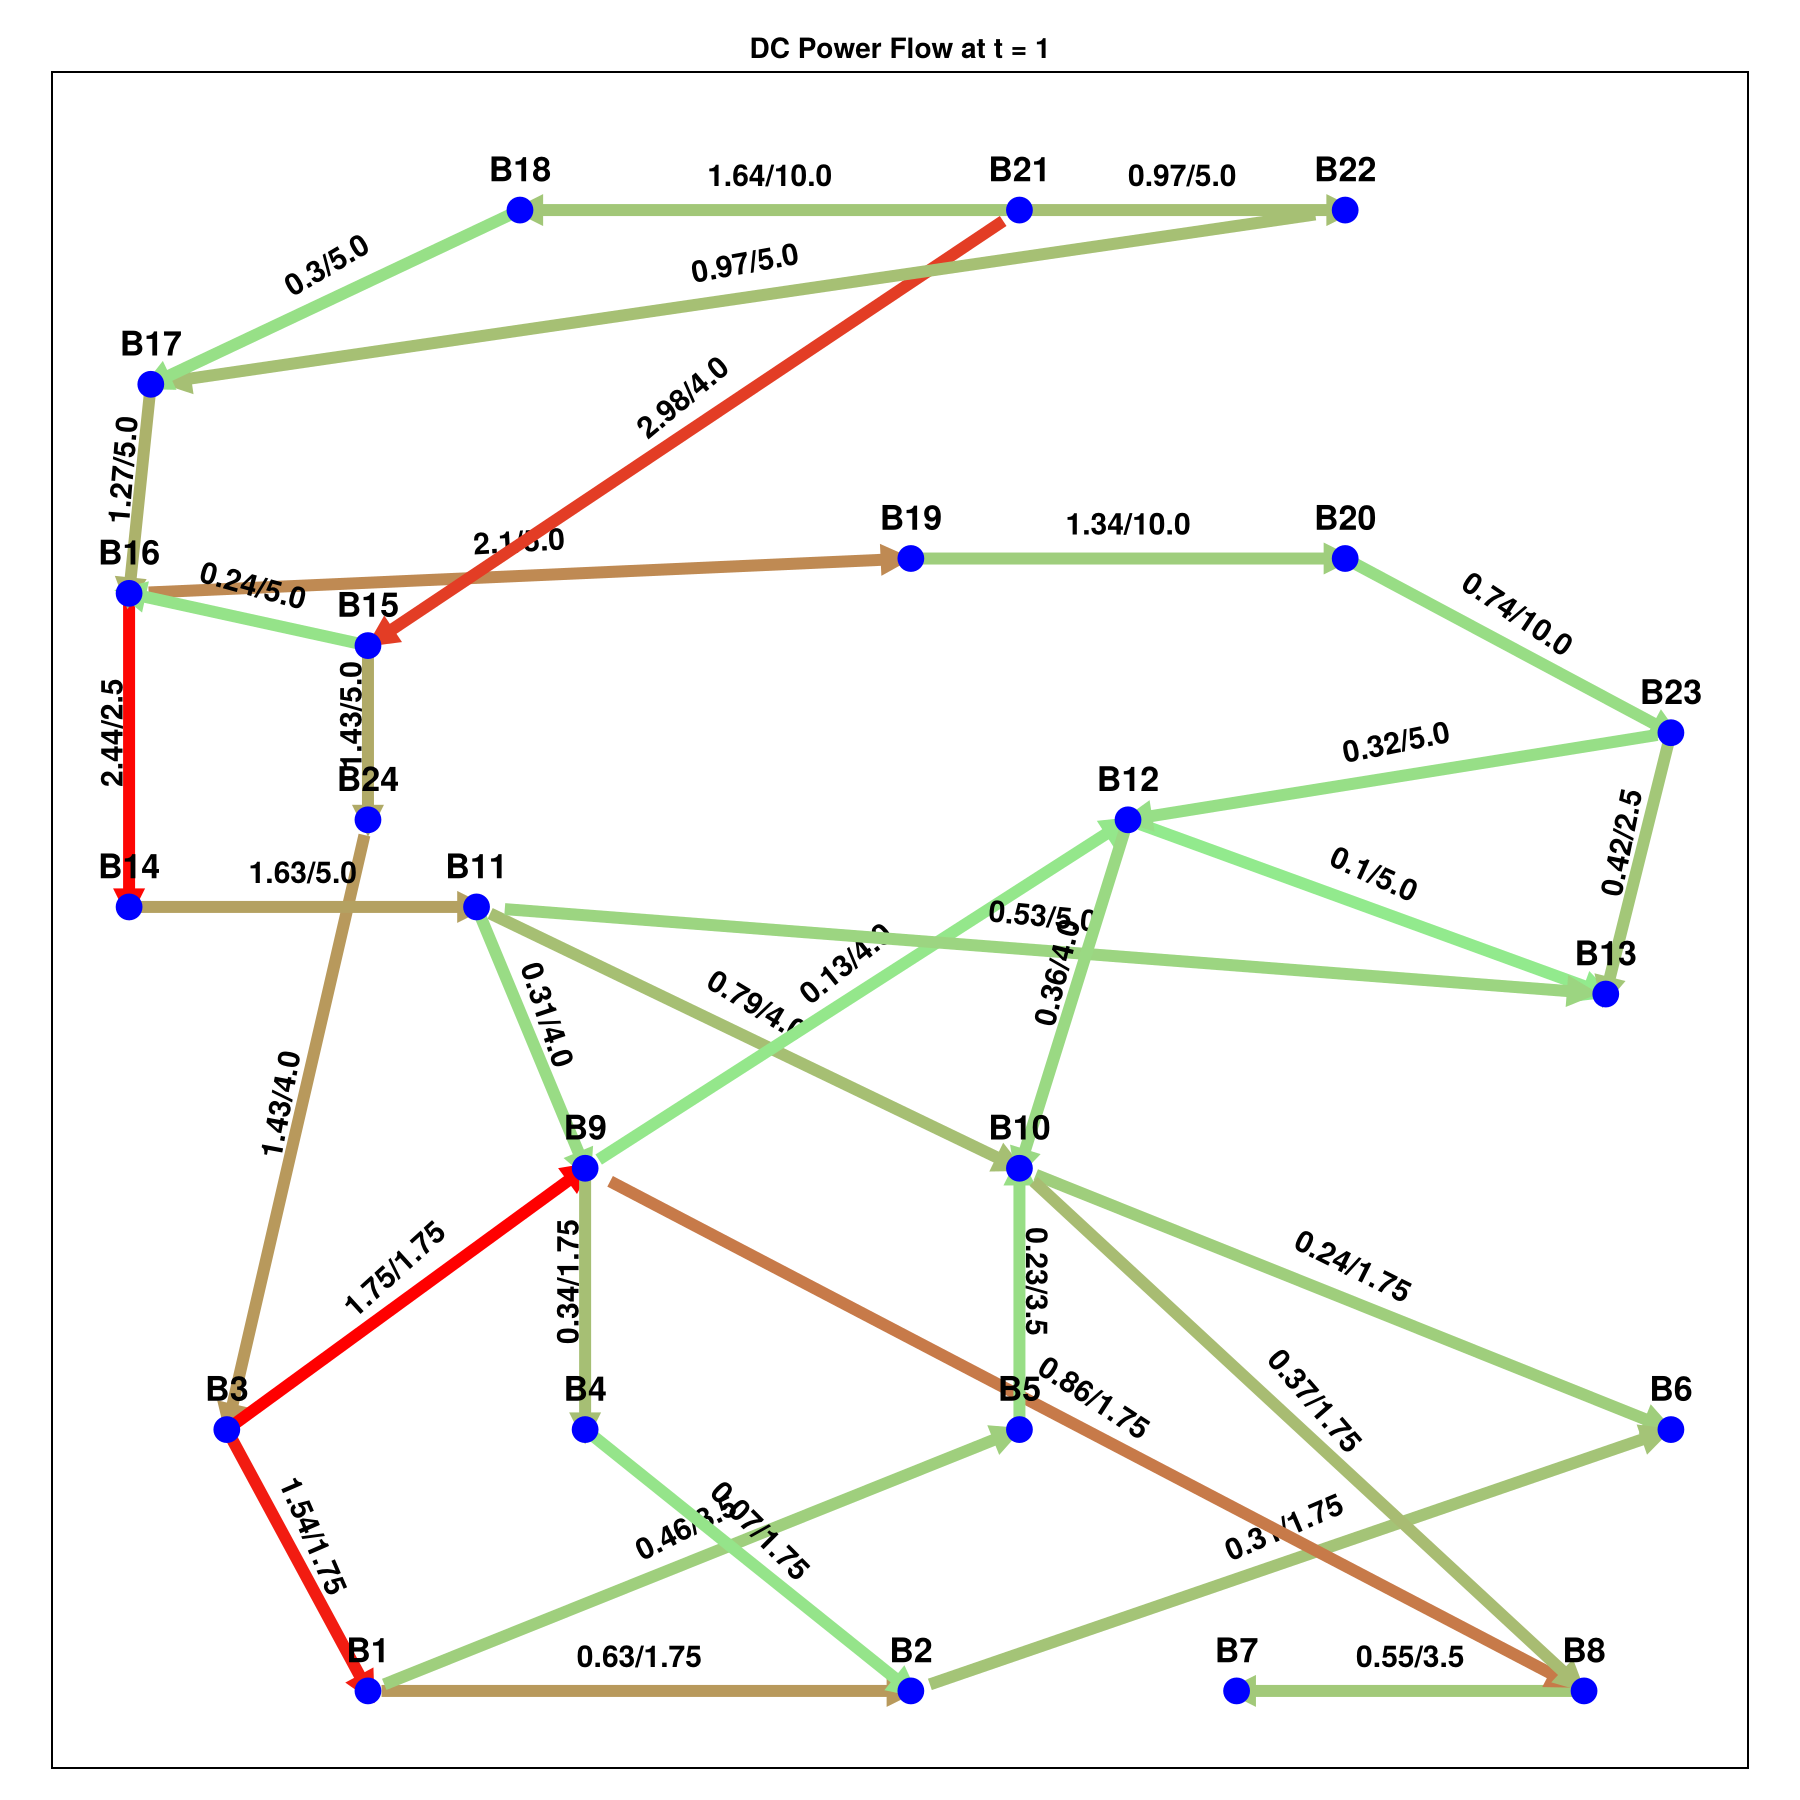

In [129]:
plot_powerflow(model_n)